<a href="https://colab.research.google.com/github/antonellafontanetto/Achivos-Extras/blob/main/Ejemplo_modelo_regresi%C3%B3n_lineal_etapas_fracturadas_YPF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   anio  prediccion_fracturas
0  2025                9313.0
1  2026               10504.0
2  2027               11695.0
3  2028               12886.0


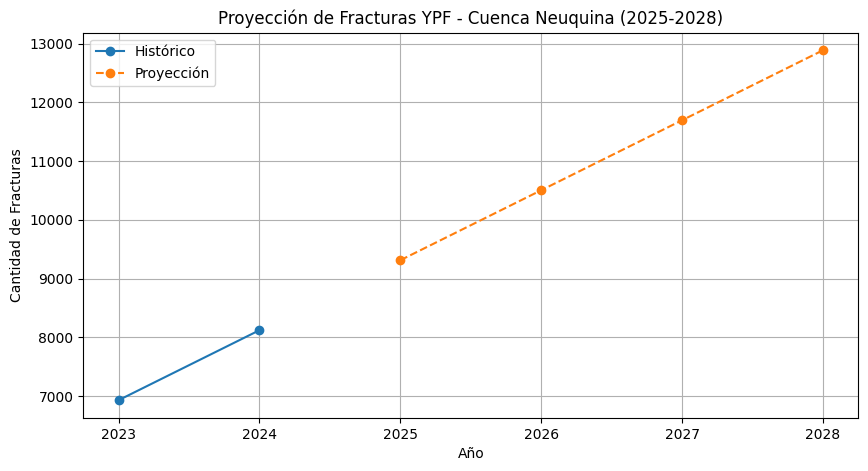

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv("/content/datosdefracturadepozos.zip")

# Filtrar por YPF, cuenca Neuquina y años desde 2023
df_filtered = df[
    (df["empresa_informante"] == "YPF S.A.") &
    (df["cuenca"] == "NEUQUINA") &
    (df["anio"] >= 2023)
]

# Seleccionar y agregar por año
df_model = df_filtered[[
    "anio", "cantidad_fracturas",
    "arena_bombeada_nacional_tn",
    "longitud_rama_horizontal_m",
    "agua_inyectada_m3"
]]

df_aggregated = df_model.groupby("anio").agg({
    "cantidad_fracturas": "sum",
    "arena_bombeada_nacional_tn": "sum",
    "longitud_rama_horizontal_m": "mean",
    "agua_inyectada_m3": "sum"
}).reset_index()

# Entrenar modelo con datos hasta 2024
train_data = df_aggregated[df_aggregated["anio"] < 2025]
X_train = train_data[[
    "arena_bombeada_nacional_tn",
    "longitud_rama_horizontal_m",
    "agua_inyectada_m3"
]]
y_train = train_data["cantidad_fracturas"]

model = LinearRegression()
model.fit(X_train, y_train)

# Extrapolación lineal de features a 2025-2028
def extrapolate_feature(feature_name, years_range):
    X = train_data["anio"].values.reshape(-1, 1)
    y = train_data[feature_name].values
    reg = LinearRegression()
    reg.fit(X, y)
    return reg.predict(np.array(years_range).reshape(-1, 1))

years_future = list(range(2025, 2029))
arena_future = extrapolate_feature("arena_bombeada_nacional_tn", years_future)
longitud_future = extrapolate_feature("longitud_rama_horizontal_m", years_future)
agua_future = extrapolate_feature("agua_inyectada_m3", years_future)

# Crear DataFrame con features proyectadas
df_future = pd.DataFrame({
    "anio": years_future,
    "arena_bombeada_nacional_tn": arena_future,
    "longitud_rama_horizontal_m": longitud_future,
    "agua_inyectada_m3": agua_future
})

# Predecir fracturas
X_input = df_future[[
    "arena_bombeada_nacional_tn",
    "longitud_rama_horizontal_m",
    "agua_inyectada_m3"
]]
df_future["prediccion_fracturas"] = model.predict(X_input)

# Mostrar resultados
print(df_future[["anio", "prediccion_fracturas"]])

# Gráfico
plt.figure(figsize=(10,5))
plt.plot(train_data["anio"], train_data["cantidad_fracturas"], marker="o", label="Histórico")
plt.plot(df_future["anio"], df_future["prediccion_fracturas"], marker="o", linestyle="--", label="Proyección")
plt.xlabel("Año")
plt.ylabel("Cantidad de Fracturas")
plt.title("Proyección de Fracturas YPF - Cuenca Neuquina (2025-2028)")
plt.legend()
plt.grid(True)
plt.show()